# `CLOUD.jl` - 2D linear advection

In [37]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../../ResearchDocs/ICCFD2022/"
results_path = "../results/advection_dgsem_2D/";

Define the physical problem

In [38]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a DGSEM scheme of degree `p` with `M` elements

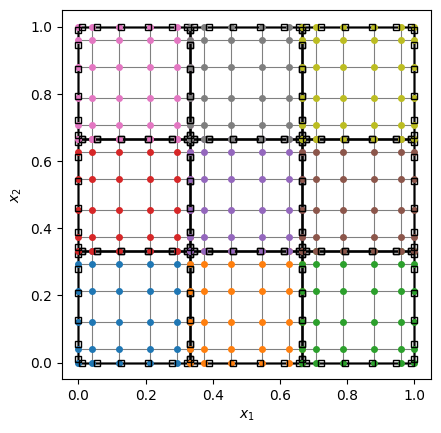

In [39]:
M = 3  # number of elements
p = 5  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGSEM(p), Quad(), N_plot=ceil(Int,50/M), 
    volume_quadrature_rule=LGLQuadrature(),
    facet_quadrature_rule=LGQuadrature())
spatial_discretization = SpatialDiscretization(
    uniform_periodic_mesh(reference_approximation.reference_element, 
        ((0.0,L),(0.0,L)), (M,M)), reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data,
     WeakConservationForm(), (0.0, T), Lazy(),
     results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", 
    plot_volume_nodes=true, grid_lines=true)

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [40]:
reset_timer!()
n_s = 50
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            3.13s / 96.7%           2.41GiB / 100%     

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   18.7k    3.02s   100%   162μs   2.41GiB  100%    135KiB
   eval residual         168k    1.26s  41.7%  7.49μs   1.07GiB  44.5%  6.67KiB
     volume terms        168k    695ms  23.0%  4.13μs    877MiB  35.6%  5.33KiB
     facet terms         168k   67.8ms  2.24%   403ns   43.7MiB  1.77%     272B
     mass matrix solve   168k   40.7ms  1.34%   241ns   59.1MiB  2.40%     368B
   eval numerical flux   168k    440ms  14.5%  2.61μs    530MiB  21.5%  3.22KiB
   extrapolate solu...   168k    269ms 

Visualize the solution

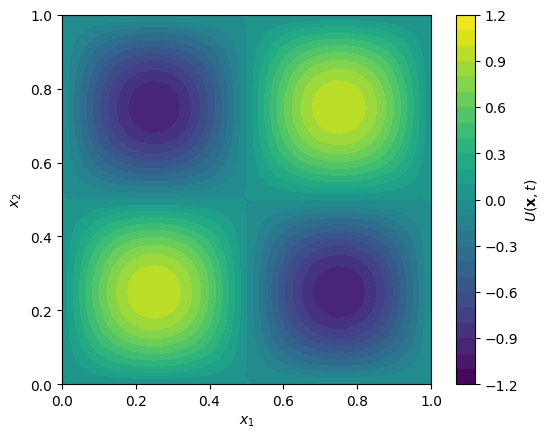

In [41]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

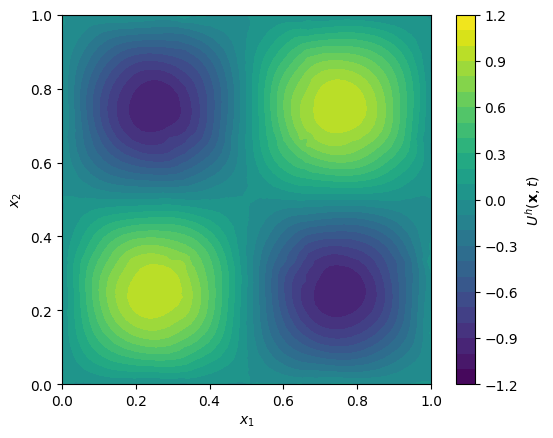

In [42]:
visualize(last(sol.u),plotter, "approx.pdf", u_range=[-1.0,1.0], contours=25, 
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [43]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.009907674785428887]
Conservation (initial/final/diff):
[1.3877787807814457e-17][1.0408340855860843e-16][9.020562075079397e-17]
Energy (initial/final/diff):
[0.24999999999999928][0.25009815888318015][9.815888318087662e-5]
